In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium
from collections import defaultdict
import mountain_lite

In [2]:
np.random.seed(123)
random.seed(123)

In [3]:
with open('trajectories.pickle', 'rb') as fd:
    D = pickle.load(fd)

1. Load the trajectories and perform MC evaluation for $v_\pi(s)$.

In [4]:
def mc_prediction(trajectories, gamma=1, env_height=31, env_width=100):
    # initialize value function to zero for all states
    V = np.zeros((env_height, env_width))
    # initialize returns to an empty list for all states
    returns = {(i, j): [] for i in range(env_height) for j in range(env_width)}

    # process each trajectory
    for i, trajectory in enumerate(trajectories):
        G = 0
        states_and_returns = []

        # reverse the trajectory to calculate returns from the end
        for state, _, reward, _ in reversed(trajectory):
            G = gamma * G + reward
            states_and_returns.append((state, G))

        # track visited states for first-visit MC
        states_visited = set()

        # update the value function for the states, but only for first visit
        for state, G in reversed(states_and_returns):
            if state not in states_visited:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                states_visited.add(state)

    return V

In [5]:
value_function = mc_prediction(D)

2. Load the trajectories and perform MC evaluation for $q_\pi(a,s)$.

In [6]:
def mc_action_value_prediction(trajectories, gamma=1, env_height=31, env_width=100, action_space=8):
    # initialize action-value function to zero for all state-action pairs
    Q = np.zeros((env_height, env_width, action_space))
    # initialize a dictionary to store returns for all state-action pairs
    returns = {(i, j, a): [] for i in range(env_height) for j in range(env_width) for a in range(action_space)}

    # process each trajectory
    for trajectory in trajectories:
        G = 0  # discounted return
        state_action_returns = []

        # reverse the trajectory to calculate returns from the end
        for state, action, reward, _ in reversed(trajectory):
            G = gamma * G + reward
            state_action_returns.append((state, action, G))

        # track visited state-action pairs for first-visit MC
        state_action_visited = set()

        # update the action-value function for the state-action pairs, but only for first visit
        for state, action, G in reversed(state_action_returns):
            if (state, action) not in state_action_visited:
                returns[(state[0], state[1], action)].append(G)
                # update the Q value as the average of returns for this state-action pair
                Q[state[0], state[1], action] = np.mean(returns[(state[0], state[1], action)])
                state_action_visited.add((state, action))

    return Q

In [7]:
action_value_function = mc_action_value_prediction(D)

3. Plot the state-value function $v_\pi(s)$.

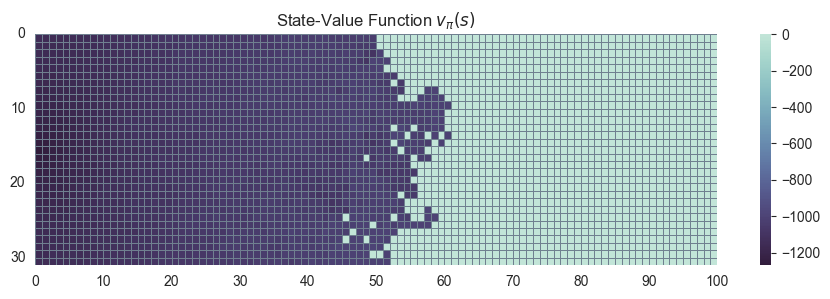

In [8]:
custom_cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.figure(figsize=(11, 3))
sns.heatmap(value_function, cmap=custom_cmap, linewidths=0.5, linecolor='slategrey')
plt.title('State-Value Function $v_\pi(s)$')
plt.xticks(ticks=[*range(0, 101, 10)], labels=[*range(0, 101, 10)])
plt.yticks(ticks=[*range(0, 31, 10)], labels=[*range(0, 31, 10)])
plt.show()

5. (*) Can you perform MC improvement? If so, perform it and explain whether the new policy is optimal or not.

In [9]:
def mc_policy_improvement(Q):
    new_policy = np.argmax(Q, axis=2)
    return new_policy

In [10]:
mc_policy_improvement(action_value_function)

array([[2, 6, 2, ..., 0, 0, 0],
       [4, 5, 6, ..., 0, 0, 0],
       [4, 6, 6, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [3, 3, 4, ..., 0, 0, 0],
       [3, 7, 5, ..., 0, 0, 0]])

In [11]:
env = gymnasium.make('mountain_lite/GridWorld-v0')

7. (*) Choose a starting policy for the robot, and justify your choice.

In [12]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [13]:
def eps_soft_policy(Q, epsilon, action_space):
    # define an epsilon-soft policy function based on the Q table
    def policy_func(state):
        # initialize a uniform distribution for all actions with a bias of epsilon
        prob_distribution = np.ones(action_space) * epsilon / action_space
        # use random_argmax to choose the action with the highest Q value (with ties broken arbitrarily)
        best_action = random_argmax(Q[state])
        # increase the probability of taking the best action by 1 - epsilon
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

8. Perform MC control and learn an optimal policy for the robot.

In [14]:
def mc_control_epsilon_greedy(env, num_episodes, episode_steps=500, gamma=1, epsilon=0.1, env_height=31, env_width=100):
    # initialize the Q table for storing the action value function
    Q = np.zeros((env_height, env_width, env.action_space.n))
    # initialize the policy using the epsilon-soft method
    policy = eps_soft_policy(Q, epsilon, env.action_space.n)
    # initialize a dictionary to store returns for all state-action pairs
    returns = {(i, j, a): [] for i in range(env_height) for j in range(env_width) for a in range(env.action_space.n)}

    # loop through each episode
    for i in range(1, num_episodes + 1):
        if i % 100 == 0:
            print(f"\rEpisode {i}/{num_episodes}.", end="")

        # initialize an empty trajectory for the current episode
        trajectory = []
        # reset the environment and get the initial state
        state = env.reset()[0]
        for _ in range(episode_steps):
            # get action probabilities from the policy
            probs = policy(tuple(state["agent"]["pos"]))
            # choose an action based on the policy
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # take the action in the environment
            next_state, reward, done, _, _ = env.step(action)
            # append experience to the trajectory
            trajectory.append((tuple(state["agent"]["pos"]), action, reward))
            if done:
                break  # exit the loop if the agent has reached the target
            state = next_state

        G = 0  # the return
        state_action_returns = []  # returns for each state-action pair in the episode
        for state, action, reward in reversed(trajectory):
            # update the return using the reward and discount factor
            G = gamma * G + reward
            state_action_returns.append((state, action, G))

        # track visited state-action pairs to ensure first-visit MC
        state_action_visited = set()

        # update Q values for first-visit state-action pairs in the episode
        for state, action, G in reversed(state_action_returns):
            if (state, action) not in state_action_visited:
                returns[(state[0], state[1], action)].append(G)
                # update the Q value as the average of returns for this state-action pair
                Q[state[0], state[1], action] = np.mean(returns[(state[0], state[1], action)])
                state_action_visited.add((state, action))  # mark state-action pair as visited

    return Q, policy

In [15]:
mc_control_Q, mc_control_optimal_policy = mc_control_epsilon_greedy(env, num_episodes=1000)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not wit

Episode 1000/1000.

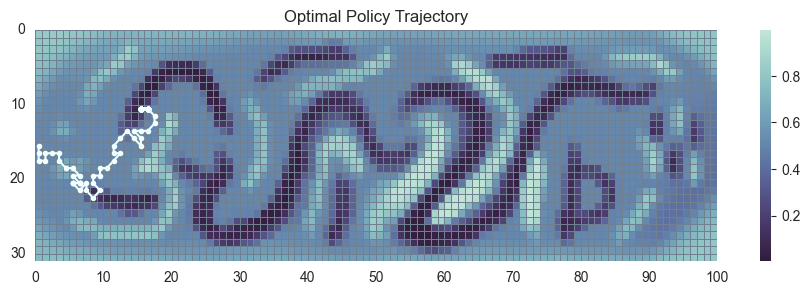

In [16]:
state = env.reset()[0]
trajectory = [tuple(state['agent']['pos'])]
for _ in range(500):
    action = np.argmax(mc_control_optimal_policy(tuple(state['agent']['pos'])))
    # print(state, policy(tuple(state['agent']['pos'])), action)
    state, reward, done, _, _ = env.step(action)
    trajectory.append(tuple(state['agent']['pos']))

custom_cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.figure(figsize=(11, 3))
sns.heatmap(env.unwrapped.MAP, cmap=custom_cmap, linewidths=0.5, linecolor='slategrey')

trajectory = np.array(trajectory)
plt.plot(trajectory[:, 1] + 0.5, trajectory[:, 0] + 0.5, color='azure', marker='.')
plt.title('Optimal Policy Trajectory')
plt.xticks(ticks=[*range(0, 101, 10)], labels=[*range(0, 101, 10)])
plt.yticks(ticks=[*range(0, 31, 10)], labels=[*range(0, 31, 10)])

plt.show()

10. Implement SARSA(0) and use it to learn an optimal policy for the robot.

In [60]:
def sarsa(env, num_episodes, episode_steps=500, alpha=0.1, gamma=1, epsilon=0.1, env_height=31, env_width=100):
    Q = np.zeros((env_height, env_width, env.action_space.n))

    #fFunction to choose an action using an epsilon-greedy policy
    def policy(state, Q, epsilon):
        if np.random.random() < epsilon:
            return env.action_space.sample()  # explore: random action
        else:
            return np.argmax(Q[state])  # exploit: best action based on current Q-values

    for episode in range(num_episodes):
        state = env.reset()[0]
        action = policy(tuple(state["agent"]["pos"]), Q, epsilon)

        for _ in range(episode_steps):
            # take the action (a) and observe the outcome state(s') and reward (r)
            next_state, reward, done, _, _ = env.step(action)

            # choose the next action (a') using policy derived from Q (epsilon-greedy)
            next_action = policy(tuple(next_state["agent"]["pos"]), Q, epsilon)

            # SARSA update
            td_target = reward + gamma * Q[tuple(next_state["agent"]["pos"])][next_action]
            td_delta = td_target - Q[tuple(state["agent"]["pos"])][action]
            Q[tuple(state["agent"]["pos"]), action] += alpha * td_delta

            # update state and action
            state = next_state
            action = next_action

    return Q, policy

In [61]:
sarsa_Q, sarsa_policy = sarsa(env, num_episodes=1000)

/var/folders/jw/pgkdvp6n17gcz8m_r8dtjdv40000gn/T/ipykernel_18705/4064594118.py:26: RuntimeWarning: overflow encountered in add
  Q[tuple(state["agent"]["pos"]), action] += alpha * td_delta
/var/folders/jw/pgkdvp6n17gcz8m_r8dtjdv40000gn/T/ipykernel_18705/4064594118.py:26: RuntimeWarning: invalid value encountered in add
  Q[tuple(state["agent"]["pos"]), action] += alpha * td_delta
/var/folders/jw/pgkdvp6n17gcz8m_r8dtjdv40000gn/T/ipykernel_18705/4064594118.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  td_delta = td_target - Q[tuple(state["agent"]["pos"])][action]


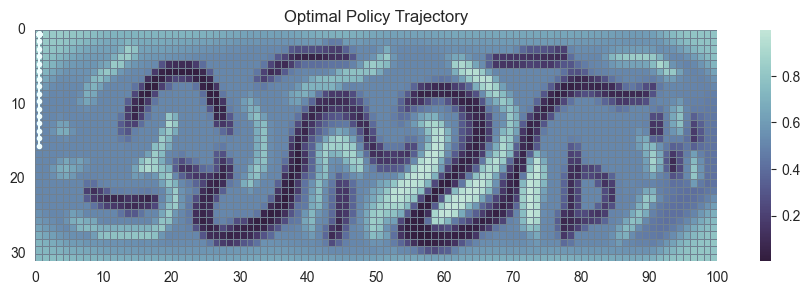

In [62]:
state = env.reset()[0]
trajectory = [tuple(state['agent']['pos'])]
for _ in range(500):
    action = np.argmax(sarsa_policy(tuple(state['agent']['pos']), sarsa_Q, epsilon=0.1))
    # print(state, policy(tuple(state['agent']['pos'])), action)
    state, reward, done, _, _ = env.step(action)
    trajectory.append(tuple(state['agent']['pos']))

custom_cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.figure(figsize=(11, 3))
sns.heatmap(env.unwrapped.MAP, cmap=custom_cmap, linewidths=0.5, linecolor='slategrey')

trajectory = np.array(trajectory)
plt.plot(trajectory[:, 1] + 0.5, trajectory[:, 0] + 0.5, color='azure', marker='.')
plt.title('Optimal Policy Trajectory')
plt.xticks(ticks=[*range(0, 101, 10)], labels=[*range(0, 101, 10)])
plt.yticks(ticks=[*range(0, 31, 10)], labels=[*range(0, 31, 10)])

plt.show()